# Computer vision - Lab 3

## Maria Musiał 156062

## Agenda



*   Definition of the convolutional operation and its graphic interpretation,
* The use of convolution in mathematics,
* The use of convolution in image processing



## Helpers

To perform the tasks, it is necessary to import the libraries used in the script and download the data on which we will be working.

In this script we will be using:
*  Image Lenna (available at the [link](http://www.lenna.org/)) - one of the most popular images historically used for testing image processing and compression,

* "Bug Challenge" - aset of pictures of ant differing in focus set to different parts of the ant(available at the [link](http://grail.cs.washington.edu/projects/photomontage/))

In [1]:
# %pip install plotly

In [2]:
# importing of libraires that will be use in the script
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# # download and unpack images
# !wget -O lena_std.tif http://www.lenna.org/lena_std.tif
# !wget -O bug.zip http://grail.cs.washington.edu/projects/photomontage/data/bug.zip && unzip -o bug.zip

The colab platform requires a special way to display images with opencv. If the notebook is run in collab, execute the following code:

In [4]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:
    def imshow(img):
        cv2.imshow('ImageWindow', img)
        cv2.waitKey()
        cv2.destroyAllWindows()

In [5]:
def h_color(a, interpolation=None):
    s = [a.shape[0] * 2, a.shape[1] * 2]
    plt.figure(figsize=s)
    plt.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=False,
        labelleft=False,
        left=False,
        right=False,
    )
    plt.imshow(a, cmap="gray", interpolation=interpolation)

In [6]:
css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td {
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 24px;
    height: 24px;
    text-align: center;
    transform: scale(1.0);
    margin: 5px;
    }
</style>
"""


def h(s):
    return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

In [7]:
def h_color_3d(z):
    fig = go.Figure(data=[go.Surface(z=z)])
    fig.update_layout(autosize=False, width=500, height=500)
    fig.show()

# Convolution

## Definition

A convolution is an operation on two functions $f$ and $g$, the result of which is a third function $(f \ast g)$. The convolution can be described by the following formula:

$$(f \ast g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t - \tau)d\tau$$

As above:
* The result of the function $(f \ast g)$ for argument $t$ is a scalar (example: a single result could be the pixel intensity at the point $t$
* this scalar is the result of the product of both functions after one is reversed and shifted by $t$,
* as a product of a function we can treat the multiplication of corresponding elements of functions and the sum of the obtained results

In image processing we will consider a discrete convolution operation where one function is an image and the other function is a mask or a kernel.

This entails some issues:
* by shifting the function $g$ by extreme values ($\infty$), the domain of both functions $g$ and $f$ can be different (e.g. $f$ can have 100 values, $g$ 10 values, and we will shift the function $g$ by 91 values $ t = $ 91). To solve this problem, the domain of the function $f$ is often supplemented with arbitrarily selected values: zero, the mean of the function $f$, etc. This operation is called **padding**,
* the result of a single convolution operation is a scalar, so convolution can be used for every 2nd, 3rd, etc. $t$ (e.g. $t \in [0, 2, 4, 6, ...]$). This parameter is called a step (**stride**). The result of the convolution with step 2 will be a new function with 2 times smaller domain,

* we can use a similar operation while matching the function $g$ to the function $f$: $$(f \ast g)(t) = \int_{-\infty}^{\infty} f(\alpha\tau)g(t - \tau)d\tau$$ where $$\alpha \in [1, 2,...]$$ This operation is called an **dilation**.


### Graphic interpretation

Autor: Vincent Dumoulin, Francesco Visin  
Article: A guide to convolution arithmetic for deep learning  
URL: [www.github.com](https://github.com/vdumoulin/conv_arithmetic)

**Blue image - input image**\
**green image - output image**

The gray area moving across the input image is function $g$. The $f$ function is a blue image, and the result is a green area (which is $f \ast g$).

#### Convolution without padding with a stride 1, and dilation 1.

* If $f$ is not padded, then the output image will be smaller by those pixels for which $g$ exceeded $f$,
* each matching $g$ to $f$ is independent of each other


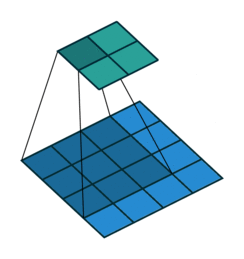

#### Convolution with padding 1, stride 1, and dilation 1.

* the padding of $f$ makes the result of the convolution the same size as $f$ (assuming that stride = 1),

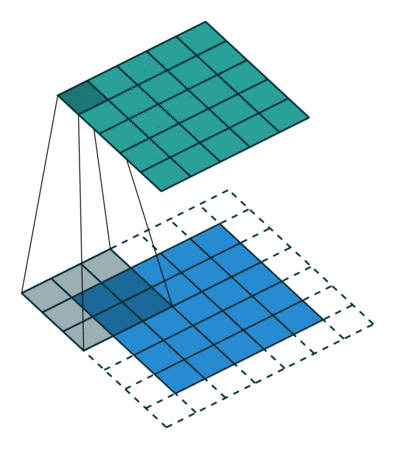

#### Convolution without padding with a stride 2, and dilation 1.

* increasing the stride makes the output image smaller (as many times as the stride) than the input image

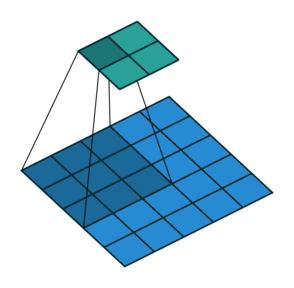

#### Convolution without padding with a stride 1, and dilation 2.

* applying an dilation without padding makes $g$ go beyond the $f$ domain more often, so if we do not add padding, the output image will be correspondingly smaller,

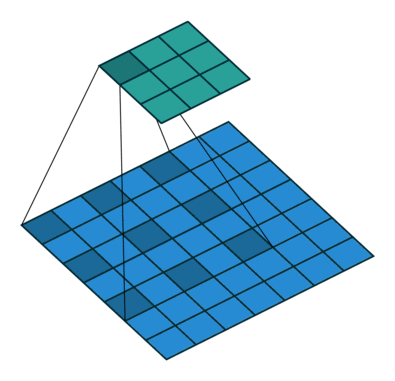

## Example

For the given tables $f$ and $g$ perform the convolution operation. Apply zero padding, unit stripe, and an dilation of 1.

$f = [1, 2, 3]$  
$g = [1, 0, 1]$

**1. After padding:**

$f = [0, 1, 2, 3, 0]$

**2. Convolution:**

Only for $t \in [0, 1, 2]$

$(f \ast g)(0) = 0 * 1 + 1 * 0 + 2 * 1 = 2$  
$(f \ast g)(1) = 1 * 1 + 2 * 0 + 3 * 1 = 4$  
$(f \ast g)(2) = 2 * 1 + 3 * 0 + 0 * 1 = 2$  

$f \ast g = [2, 4, 2]$

## Implementation of convolution in OpenCV

**NOTE: the filter2D function was used, which performs the 2D correlation.**
https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#filter2d

In order to obtain convolution one must flip the function **g**.


In [8]:
f = np.array([[1, 2, 3]], np.uint8)
g = np.array([[0, 1, 2]], np.uint8)


def cvconv(f, g):
    # padding
    pad_v = (g.shape[0] - 1) // 2 #vertical 0 padding for 1x3
    pad_h = (g.shape[1] - 1) // 2 #horizontal 1 padding
    fb = cv2.copyMakeBorder(f, pad_v, pad_v, pad_h, pad_h, cv2.BORDER_CONSTANT, 0)
    #cv2.copyMakeBorder(src, top, bottom, left, right, borderType, value
    #src: It is the source image. 
    #top: It is the border width in number of pixels in top direction. 
    # borderType: It depicts what kind of border to be added. It is defined by flags like cv2.BORDER_CONSTANT, cv2.BORDER_REFLECT, etc dest: It is the destination image
    #value: It is an optional parameter which depicts color of border if border type is cv2.BORDER_CONSTANT
    # cv2.BORDER_CONSTANT: It adds a constant colored border. The value should be given as a keyword argument
    # cv2.BORDER_REFLECT: The border will be mirror reflection of the border elements. Suppose, if image contains letters “abcdefg” then output will be “gfedcba|abcdefg|gfedcba“. 
    # cv2.BORDER_REFLECT_101 or cv2.BORDER_DEFAULT: It does the same works as cv2.BORDER_REFLECT but with slight change. Suppose, if image contains letters “abcdefgh” then output will be “gfedcb|abcdefgh|gfedcba“. 
    #cv2.BORDER_REPLICATE: It replicates the last element. Suppose, if image contains letters “abcdefgh” then output will be “aaaaa|abcdefgh|hhhhh“ 
    
    g = np.flip(g)  #reverse order of elements

    # convolution
    fg_cv = cv2.filter2D(fb.astype(g.dtype), -1, g)
    #cv2.filter2D(src, ddepth, kernel[, dst[, anchor[, delta[, borderType]]]])
    #when ddepth=-1, the output image will have the same depth as the source
    

    # remove padding from result (opencv does not do this automatically)
    return fg_cv[pad_v : fb.shape[0] - pad_v, pad_h : fb.shape[1] - pad_h]


# display
h(f)
h(g)
h(cvconv(f, g))

# 2 1 0
# 0 1 2 3 0 

1,2,3


0,1,2


1,4,7


Convolution also occurs in other libraries:
* numpy - numpy.convolve
* scipy - scipy.signal.convolve,  scipy.signal.convolve2d
* ...

### Task 1

Implement a function that for arguments **f** and **g** will perform a convolution operation. The function should handle padding, stride = 1, without dilation.



**Note 1**: Be sure not to modify f on the fly. This leads to wrong end results.

**Note 2**: The implementation operation should be adapted to the 1D and 2D data.

**Note 3**: Use the matrix operations presented in lab 1. Don't use loops that iterate over each pixel and np.apply_along_axis because it's even slower than loops.


In [9]:
from numpy.lib.stride_tricks import as_strided
import math
def conv(f, g):
    stride = 1
    g = np.flipud(np.fliplr(g))
    
    #determine size of padding
    # pad_v = math.ceil((g.shape[0] - 1) / 2) #ceil division
    # pad_h = math.ceil((g.shape[1] - 1) / 2)
    pad_v = (g.shape[0] - 1) // 2 #floor division
    pad_h = (g.shape[1] - 1) // 2
    
    #apply padding
    padded_f = np.zeros((f.shape[0] + (pad_v*2), f.shape[1] + (pad_h*2)), dtype=f.dtype) #create empty array of size of padded array    
    padded_f[pad_v : pad_v + f.shape[0], pad_h : pad_h + f.shape[1]] = f  #inserting image into padding

    strided_view = as_strided(
        padded_f,
        shape=(padded_f.shape[0] - g.shape[0] + 1, padded_f.shape[1] - g.shape[1] + 1, g.shape[0], g.shape[1]), #f:1x3: height:1-1+1=1, width:5-3+2=4, kernel shape:1, 3
        strides=(padded_f.strides[0], padded_f.strides[1], padded_f.strides[0], padded_f.strides[1])
    )
    # Perform convolution
    output = np.sum(strided_view * g[np.newaxis, np.newaxis, ...], axis=(-2, -1))

    return output
    


f = np.array([[1, 2, 3]], np.uint8)
g = np.array([[0, 1, 2]], np.uint8)

fg = conv(f, g)

h(f)
h(g)
h(fg)

1,2,3


0,1,2


1,4,7


In [10]:
def conv2d(f, g):
    return conv(f,g)

f = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
g = np.array([[1, 0], [0, -1]])


fg = conv2d(f, g)

h(f)
h(g)
h(fg)
# h(cvconv(f,g)) #doesnt work?

1,2,3
4,5,6
7,8,9


1,0
0,-1


4,4
4,4


## The mathematical application of convolution

### Derivative

For some function $ f (x) $ and the point $ x_0 $ for which environment $ f $ is defined. The derivative of the $ f $ function can be defined as:

$$f'(x_0) = \lim_{x \rightarrow x_0} \frac{f(x) - f(x_0)}{x - x_0}$$

In other words, the derivative of the function determines how much the value of the $ f $ function changes around a certain point $ x_0 $.

In practice, having a certain sample of data coming from a certain function, we only see a digitized form of this function. Then, the expression $ \lim_{x \rightarrow x_0} $ returns to the nearest value to $ x_0 $ that we have.


Example:  
For $x = \{0, 1, 2, 3\}$  
and $f(x) = \{3, 2, 1, 0\}$:  
$f'(x_0) = \frac{2 - 3}{1 - 0} = -1$

$f'(x_1) = \frac{1 - 2}{2 - 1} = -1$

$f'(x_2) = \frac{0 - 1}{3 - 2} = -1$

The above data comes from the function $ f (x) = -x +  3$, for which we can analytically compute the derivative $ f '(x) = -1 $, which agrees with the empirically calculated derivatives in points.

A simple calculation of gradients in practice comes down to the convolution operation between a certain function $ f $ and the function $ g = [-1, 1] $.



#### Example

For the sine function, let's take samples with a step **0.01** of function values from the range $ [0, 4 * \pi] $.

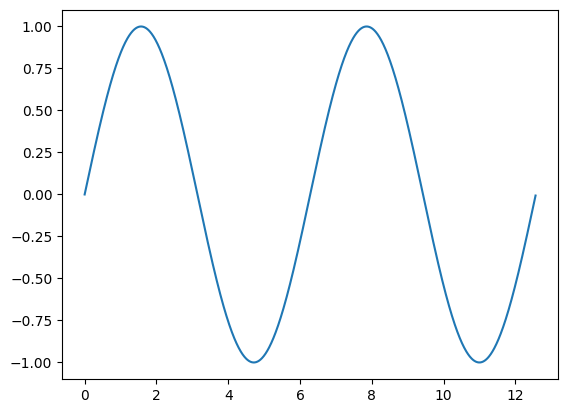

In [11]:
t = np.arange(0.0, 4.0 * np.pi, 0.01)
s = np.sin(t)

plt.plot(t, s)
plt.show()


Let's calculate the derivative ($ \frac {f (x) - f (x_0)} {x - x_0} $) in two steps:
* using convolution we can calculate the difference between adjacent values ($ f (x) - f (x_0) $),
* calculating the step size for which we generated data (0.01, or directly from the arguments $ t [n] - t [n-1] $),

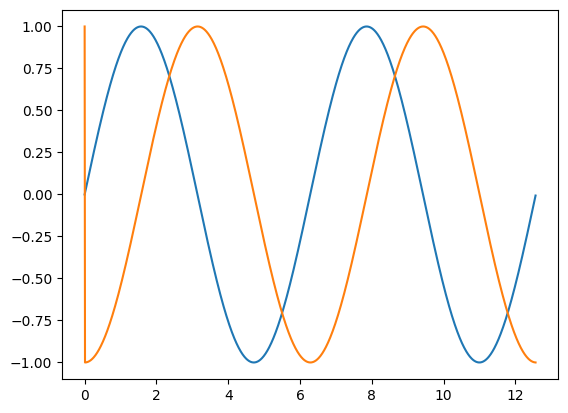

In [12]:
der = np.array([[-1, 1]], np.float32)

s_hat = cvconv(s[np.newaxis], der) / (t[1] - t[0])
s_hat = s_hat[0]

plt.plot(t, s)
plt.plot(t, s_hat)
plt.show()


The above operation resulted in a graph of the $ y = \cos (x) $ function, which is true (analytically, the derivative of $ \sin $ is $ \cos $).

#### Task 2

Using the above implementation of the derivative, find the extremes of the following function:

$$y = (x-3)x(x-1)(x-4)(x-7)$$

**Note: due to numerical errors, consider values close to 0.0 as zero. The correct result will be to print a list of arguments for which the derivative is close to zero.**

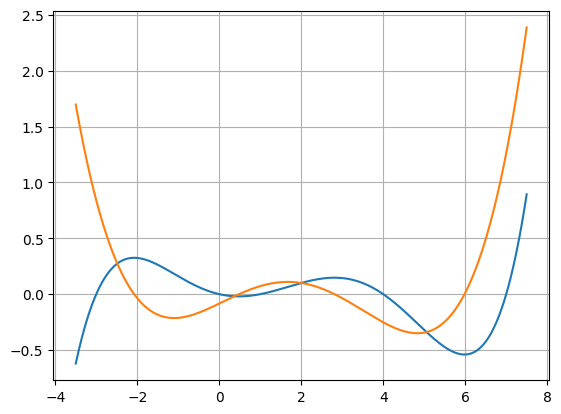

Extremes:
[-2.076  0.479  2.809  5.983]
Extremes values:
[ 0.32538528 -0.01993462  0.14734015 -0.54010097]


In [13]:
der = np.array([[1, -1]], np.float64)

x = np.arange(-3.5, 7.5, 0.001)
y = 0.001 * (x + 3) * x * (x - 1) * (x - 4) * (x - 7)

y_hat = conv(y[np.newaxis], der) / (x[1] - x[0])
y_hat = y_hat[0]
r=np.where(np.isclose(y_hat, 0, atol=0.0004))[0]

#to delete redundant extremes
min_separation = 20
filtered_r = [r[0]]
for i in range(1, len(r)):
    if r[i] - filtered_r[-1] >= min_separation:
        filtered_r.append(r[i])

extremes = x[filtered_r]
extremes_values = y[filtered_r]


plt.plot(x, y, label="f(x)")
plt.plot(x[:-1], y_hat, label="f'(x)")
plt.grid()
plt.show()
print("Extremes:")
print(extremes)
print("Extremes values:")
print(extremes_values)


### 2D derivative

We identified images as 2-dimensional functions. This means that we can also count derivatives for them.

The derivative for 2D images has an important property: for changes in the function (image) value, i.e. for places where the pixel intensity is different, the derivative will return a value other than zero.




Let's define a simple binary image, shown below.

In [14]:
# %pip install nbformat

In [15]:
s = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
    ],
    np.float32,
)

h_color_3d(s)

Then, we can define two functions that calculate the derivative for horizontal and vertical data, respectively:

In [16]:
der_h = np.array([[-1, 1]], np.float32)
der_v = np.array([[-1], [1]], np.float32)

h_color_3d(cvconv(s, der_h) / (t[1] - t[0]))
h_color_3d(cvconv(s, der_v) / (t[1] - t[0]))


### 2nd order derivative

To better detect areas where the color intensity differences are greater, you can find areas where the 1st order derivative quickly increases / decreases. This is where the edges of the objects in the image lie.

To calculate such places, we can calculate the derivative of the calculated derivative, i.e. the derivative of the 2nd order.

The formula for the derivative:

$$f'(x_0) = \lim_{x \rightarrow x_0} \frac{f(x) - f(x_0)}{x - x_0}$$

Images are functions with unit-varying arguments (e.g. pixel with position (0,0), (0,1), (0, ...). This means that: $$ \lim_{x \rightarrow x_0} x - x_0 =  1$$
 So we can write the derivative for the image as:

$$f'(x_0) = \frac{f(x_1) - f(x_0)}{x_1 - x_0} = f(x_1) - f(x_0)$$


Then the 2nd order derivative takes the form:

$$f''(x_0) = (f(x_1) - f(x_0))'$$
$$f''(x_0) = f'(x_1) - f'(x_0)$$
$$f''(x_0) = f(x_2) - f(x_1) - f(x_1) + f(x_0)$$
$$f''(x_0) = f(x_2) -2 f(x_1) + f(x_0)$$

The above formula can be realized using the convolution with the function $ g = [1, -2, 1] $.

Let's define an image whose edges are not so visible.

In [17]:
s = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0.8, 0.5, 0.1, 0, 0],
        [0, 1, 1, 0.8, 0.6, 0.2, 0, 0],
        [0, 1, 1, 1, 0.7, 0.3, 0.05, 0],
        [0, 1, 1, 1, 0.7, 0.3, 0.05, 0],
        [0, 1, 1, 1, 0.5, 0.3, 0, 0],
        [0, 1, 1, 1, 0.3, 0.1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
    ],
    np.float32,
)

der_h = np.array([[1, -2, 1]], np.float32)
der_v = np.array([[1], [-2], [1]], np.float32)

h_color_3d(s)
h_color_3d(cvconv(s, der_h))
h_color_3d(cvconv(s, der_v))

Performing the derivative of the 2nd order horizontally we use the function $ g = [[-1, 2, -1]] $, which has the size (1, 3). Its operation is equal to convolution with the function:

$$g_h = \begin{bmatrix}
0 & 0 & 0\\
-1 & 2 & -1\\
0 & 0 & 0\\
\end{bmatrix}$$

Similarly for the 2nd order derivative vertically:

$$g_v = \begin{bmatrix}
0 & -1 & 0\\
0 & 2 & 0\\
0 & -1 & 0\\
\end{bmatrix}$$

Both functions can be combined with the addition operation, obtaining the function:

$$g = \begin{bmatrix}
0 & -1 & 0\\
-1 & 4 & -1\\
0 & -1 & 0\\
\end{bmatrix}$$

This is called the **Laplasjan** operator, which can be used to detect edges vertically and horizontally simultaneously.


In [18]:
der = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], np.float32)

h_color_3d(cvconv(s, der))
h_color_3d(np.abs(cvconv(s, der)))

## Popular convolution operations

The OpenCV library contains ready-made implementations of many convolutional operations. The most popular are:
* **blur** - based on the mean of adjacent pixels (equal weights),
* **gaussian blur** - weighted pixel blur according to the Gaussian distribution,
* **laplacian**,
* **sobel** (edge detection),
* **median filter**,
* **bilateral** - weighted pixel blur based on Gaussian distribution and pixel intensity difference

The results of their implementation in OpenCV are presented below.

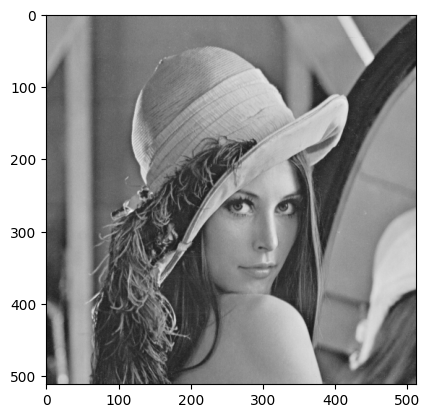

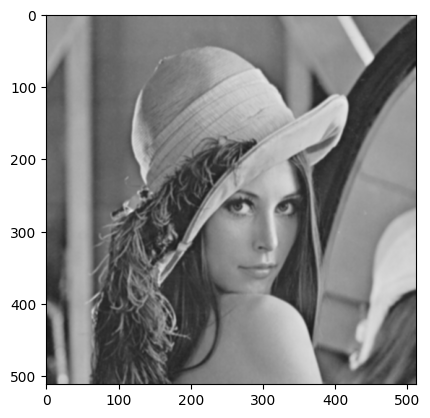

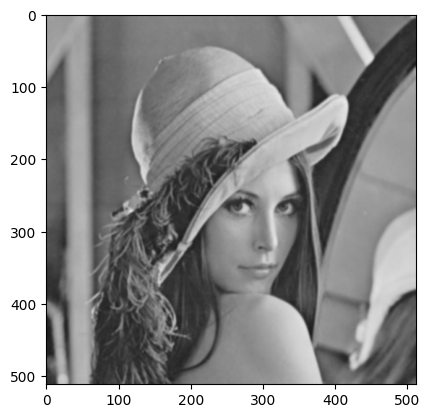

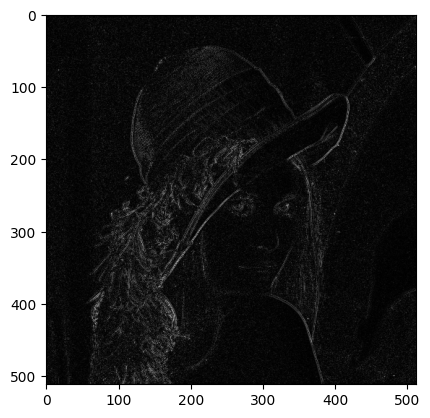

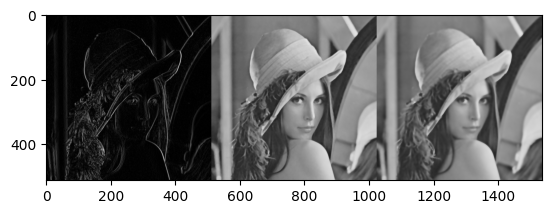

In [19]:
img = cv2.imread("./lena_std.tif", 1)
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# imshow(img_grayscale)

img_blur = cv2.blur(img_grayscale, (3, 3))
img_gaussian_blur = cv2.GaussianBlur(img_grayscale, (5, 5), 0)

img_laplacian = cv2.Laplacian(img_grayscale, cv2.CV_32F)
img_laplacian = cv2.normalize(np.abs(img_laplacian), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
img_sobel = cv2.Sobel(img_grayscale, cv2.CV_64F, 1, 0, ksize=3)
img_sobel = cv2.normalize(np.abs(img_sobel), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

img_median = cv2.medianBlur(img_grayscale, 5)
img_bilateral = cv2.bilateralFilter(img_grayscale, 9, 75, 75)

plt.imshow(cv2.cvtColor(img_grayscale, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_gaussian_blur, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_laplacian, cv2.COLOR_BGR2RGB))

plt.show()
plt.imshow(cv2.cvtColor(np.concatenate([img_sobel, img_median, img_bilateral], 1), cv2.COLOR_BGR2RGB))

### Task 3

Prepare the $g_1 $ and $ g_2 $ functions for the **blur** and **gaussian blur** operations respectively.

Perform a convolution operation with these functions on the image `` Lenna '' in RGB format.

**Note: Use only numpy and python.**

In [20]:
def blur_kernel(size):
    g = np.full((size,size), 1/size**2)
    return g


def gaussian_kernel(size, sig=3.0):
    x, y = np.meshgrid(np.linspace(-(size //2), size //2, size),
                       np.linspace(-(size //2), size //2, size))  #returns evenly spaced intervals from -size/2 to size/2 
    
    normal = 1/(2  * np.pi * sig**2)

    gauss = np.exp(-(x**2+y**2) / (2 * sig**2)) * normal  #gaussian function
    return gauss


g1 = blur_kernel(11)
g2 = gaussian_kernel(21)

img_g1 = cvconv(img, g1)
img_g1 = img_g1.astype(np.uint8)

img_g2 = cvconv(img, g2)
img_g2 = rescale_intensity(img_g2) * 255.0
img_g2 = img_g2.astype(np.uint8)


imshow(np.concatenate([img, img_g1, img_g2], 1))
# imshow(cv2.GaussianBlur(img, (21, 21), 3))


## Edge detection

A practical use of Laplasjan is edge detection. By defining the $ g $ function as:

$$g = \begin{bmatrix}
0 & -1 & 0\\
-1 & 4 & -1\\
0 & -1 & 0\\
\end{bmatrix}$$

and by applying convolution on the image in the **grayscale**, we can perform simple edge detection.

In the beginning, to remove noise and local pixel perturbations, a Gaussian blur is recommended to start with.

In [21]:
img = cv2.imread("./lena_std.tif", 1)
g = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], np.float32)

img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0
img_smoothed  = cv2.GaussianBlur(img_grayscale, (5, 5), 1.0)
img_laplase = cv2.filter2D(img_grayscale, -1, g)
img_smoothed_laplase = cv2.filter2D(img_smoothed, -1, g)

imshow(np.concatenate([img_grayscale, img_laplase, img_smoothed_laplase], 1))

At edge points in the intensity function (where the function suddenly changes direction), **the first derivative has an extremum** (a local maximum or minimum). The second derivative at these points changes sign, meaning it crosses zero. Therefore, an edge is where **the second derivative has a zero-crossing** where it changes from positive to negative or vice versa.

Extreme Laplacian values may indicate high image sharpness.

In [22]:
img_padded = np.pad(img_smoothed_laplase, pad_width=1, mode='edge')


#  Use sliding_window_view to find zero crossings
windows = sliding_window_view(img_padded, (3, 3))  #sliding across all dimensions, extracting subsets of the array at all window positions

# Zero-crossing condition: different signs in the 3x3 window
min_vals = windows.min(axis=(2, 3))
max_vals = windows.max(axis=(2, 3))
zero_crossing = (min_vals < 0) & (max_vals > 0)

zero_crossing = np.uint8(zero_crossing)
# imshow(zero_crossing*255.0)

imshow(np.concatenate([img_grayscale, np.abs(img_laplase), img_laplase, zero_crossing], 1))

Zero-crossings in the second derivative can often produce numerous false positives due to the presence of ripples and textures in the image. To mitigate this issue, we compute the local variance around each pixel, as a true edge typically corresponds to a significant change in intensity in the original image. If the local variance is low, it suggests that the zero-crossing is likely caused by ripple effects rather than a genuine edge.

In [23]:
kernel_size = 5
local_variance = cv2.blur(img_smoothed**2, (kernel_size, kernel_size)) - cv2.blur(img_smoothed, (kernel_size, kernel_size))**2 #mean of square - square of mean
local_variance = rescale_intensity(local_variance)  #rescale to [0,1] or [0,255]
threshold = 0.03
edges_variance  = np.zeros_like(zero_crossing)

edges_variance [(zero_crossing == 0) & (local_variance > threshold)] = 255

imshow(np.concatenate([img_grayscale, local_variance, edges_variance ], 1))

A similar effect can be achieved by analyzing the magnitude of the first derivative, as significant edges in the image will exhibit a pronounced gradient, however, this approach tends to be noisier than using local variance.

In [24]:
grad_x = cv2.Sobel(img_grayscale, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(img_grayscale, cv2.CV_64F, 0, 1, ksize=3)

magnitude = np.sqrt(grad_x**2 + grad_y**2)

threshold = 0.2
edges_sobel = np.zeros_like(zero_crossing)


edges_sobel[(zero_crossing == 0) & (magnitude > threshold)] = 255

imshow(np.concatenate([img_grayscale, edges_variance, edges_sobel], 1))

### Task 4

**Ant challenge** is an image reconstruction problem from multiple intermediate images that contain details relevant to the result. The data includes pictures of the ant (in relatively the same pose) with focus at different distances from the lens.

The task is to propose an image reconstruction algorithm that will contain the sharpest areas from individual frames.

Tips:
* fill in only the contents of the functions **detect_prec** and **merge**,
* the **detect_pre** function should retrieve a single image of an ant in RGB format and return a mask in the $[0, 1] $ range, where sharp areas will have values close to 1,
* the **merge** function should retrieve a list of ant images and the corresponding results of the **detect_prec** function. The function should perform **valid sum of pixels from the list of ant images** for each resultant, where the weights should be the results of the **detect_prec** function,
* to enhance the results, you can use the gamma correction performed on the result of the **detect_prec** function.

In [26]:
files = [
    "./bug/b_bigbug0000_croppped.png",
    "./bug/b_bigbug0001_croppped.png",
    "./bug/b_bigbug0002_croppped.png",
    "./bug/b_bigbug0003_croppped.png",
    "./bug/b_bigbug0004_croppped.png",
    "./bug/b_bigbug0005_croppped.png",
    "./bug/b_bigbug0006_croppped.png",
    "./bug/b_bigbug0007_croppped.png",
    "./bug/b_bigbug0008_croppped.png",
    "./bug/b_bigbug0009_croppped.png",
    "./bug/b_bigbug0010_croppped.png",
    "./bug/b_bigbug0011_croppped.png",
    "./bug/b_bigbug0012_croppped.png",
]

#simple laplace. works best here
def detect_prec(img):
    g = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], np.float32)
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) /255.0
    img_laplase = cv2.filter2D(img_grayscale, -1, g)
    img_laplase = rescale_intensity(np.abs(img_laplase))
        
    return img_laplase

def merge(bugs, bugs_prec):
    combined_bugs = np.zeros_like(bugs[0], dtype=np.float32)
    combined_weights = np.zeros_like(bugs_prec[0], dtype=np.float32)
    
    for i in range(len(bugs)):
      weight_map = bugs_prec[i][:, :, np.newaxis]
      combined_bugs += weight_map * bugs[i]
      combined_weights += bugs_prec[i]
      
    combined_weights[combined_weights == 0] = 1e-8
    combined_bugs /= combined_weights[:,:, np.newaxis]
    
    return combined_bugs.astype(np.uint8)


# data loading
bugs = [cv2.imread(f, 1) for f in files]
bugs = list(map(lambda i: cv2.resize(i, None, fx=0.3, fy=0.3), bugs))
bugs_prec = list(map(detect_prec, bugs))

# load the ground truth image
result = cv2.imread("./bug/result.png", 1)
result = cv2.resize(result, None, fx=0.3, fy=0.3)

print("\n===")
print("Pictures of ants with different sharpness at different distances\n")
imshow(np.concatenate(bugs[0:4], 1))
imshow(np.concatenate(bugs[4:8], 1))
imshow(np.concatenate(bugs[8:12], 1))

imshow((np.concatenate(bugs_prec[0:4], 1) * 255).astype(np.uint8))
imshow((np.concatenate(bugs_prec[4:8], 1) * 255).astype(np.uint8))
imshow((np.concatenate(bugs_prec[8:12], 1) * 255).astype(np.uint8))

bug_combined = merge(bugs, bugs_prec)
bug = np.stack(bugs, 0).mean(0).astype(np.uint8)

print("\n===")
print("Normal averaging of the component images and the target image\n")
imshow(np.concatenate([result, bug], 1))

# print(result.shape, bug.shape, bugs[0].shape, bugs_prec[0].shape)
print("\n===")
print(
    "The result of image reconstruction based on the detection of high-sharpness areas\n"
)
imshow(np.concatenate([result, bug_combined], 1))


===
Pictures of ants with different sharpness at different distances


===
Normal averaging of the component images and the target image


===
The result of image reconstruction based on the detection of high-sharpness areas

